# LangGraph Demo
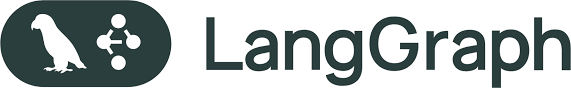
## Setup

In [17]:
from dotenv import load_dotenv
import os
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

load_dotenv()

True

## Agent definitions

In [18]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an essay assistant tasked with writing excellent 2-paragraph essays."
            " Generate the best essay possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
llm = ChatOpenAI(model="gpt-4o")
generate = prompt | llm

reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect = reflection_prompt | llm

## Graph Definition

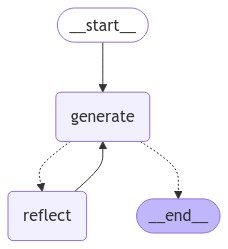

In [19]:
from typing import Annotated, List, Sequence
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]


async def generation_node(state: State) -> State:
    return {"messages": [await generate.ainvoke(state['messages'])]}


async def reflection_node(state: State) -> State:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    res = await reflect.ainvoke(translated)
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=res.content)]}


builder = StateGraph(State)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")


def should_continue(state: State):
    if len(state["messages"]) > 4:
        # End after 2 iterations
        return END
    return "reflect"

builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Execution

In [20]:
config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream({
    "messages": [
        HumanMessage(
            content="Generate an essay on how generative AI might impact humankind"
        )
    ],
}, config):
    print(event)
    print("---")

{'generate': {'messages': [AIMessage(content='The advent of generative AI heralds a transformative era, replete with potential impacts on various facets of human life. At its core, generative AI refers to systems capable of producing new content—be it text, images, music, or even code—based on learned patterns from existing data. This technology promises to revolutionize industries by enhancing productivity and creativity. In the realm of healthcare, for instance, generative AI could aid in the rapid development of new medications by simulating molecular interactions, thereby accelerating the drug discovery process. Similarly, in the creative sector, artists and writers can leverage AI tools to explore novel forms of expression, pushing the boundaries of conventional art forms. Moreover, businesses stand to benefit from AI-generated insights that can drive innovation and efficiency, leading to more personalized and effective customer experiences.\n\nHowever, the widespread adoption of 

{'reflect': {'messages': [HumanMessage(content="Your revised essay offers a compelling and nuanced view of the potential benefits and challenges associated with generative AI. It is well-organized and provides a thoughtful exploration of various sectors, from healthcare and the arts to education and finance. Here are some suggestions to further refine and expand your essay:\n\n1. **Introduction**:\n   - Your opening paragraph sets an evocative scene, but consider adding a brief historical context or a recent development in generative AI to underline the pace of technological advancement and its increasing relevance.\n\n2. **Sector-Specific Examples**:\n   - For each sector you address, consider incorporating more specific examples or case studies. For instance, mention a particular instance where AI has impacted education or finance, such as a notable AI tool used in classrooms or a financial institution that has successfully integrated AI for risk management.\n\n3. **Ethical Challenge

In [21]:
state = graph.get_state(config)
ChatPromptTemplate.from_messages(state.values["messages"]).pretty_print()

================================ Human Message =================================

Generate an essay on how generative AI might impact humankind

================================== Ai Message ==================================

The advent of generative AI heralds a transformative era, replete with potential impacts on various facets of human life. At its core, generative AI refers to systems capable of producing new content—be it text, images, music, or even code—based on learned patterns from existing data. This technology promises to revolutionize industries by enhancing productivity and creativity. In the realm of healthcare, for instance, generative AI could aid in the rapid development of new medications by simulating molecular interactions, thereby accelerating the drug discovery process. Similarly, in the creative sector, artists and writers can leverage AI tools to explore novel forms of expression, pushing the boundaries of conventional art forms. Moreover, businesses stand to 